In [15]:
# MIT License
# Copyright (c) 2020 Adam Tibi (https://linkedin.com/in/adamtibi/ , https://adamtibi.net)
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import load_model
from common_variables import *

In [ ]:
pred_interval = 1 
pred_size = 1 # Prediction length into the future
np.random.seed(seed)
tf.random.set_seed(seed)

In [42]:
df = pd.read_csv(test_time_series_path, dayfirst = True, index_col=['Date'],
                  parse_dates=['Date'], usecols=['Date','HLAvg','MA','Returns','Close','ATR'])[:]
scaler = joblib.load(scaler_path)
df['Scaled'] = scaler.transform(df[['Returns']].values)
model = load_model(model_path)


In [43]:
scaled = df['Scaled'].values

# Create empty column to store the multi predictions
df["Pred_Close_From"] =  np.nan
df["Pred_Close_To"] = np.nan

# Cache the column indices 
pred_close_from_col_index = df.columns.get_loc('Pred_Close_From')
pred_close_to_col_index = df.columns.get_loc('Pred_Close_To')


In [ ]:

ma_col_index = df.columns.get_loc('MA')
predictions_for_plot = []
df_len = df.shape[0]
decision = []
for i in range(window_size, df_len - pred_size, pred_interval):

    X = [scaled[i-window_size:i]]
    y = []
    y_ma = df.iloc[i - 1, ma_col_index]
    top_price = y_ma + abs_pips
    bottom_price = y_ma - abs_pips
    sign = 0
    for _ in range(pred_size):
        X = np.asarray(X)
        X = np.reshape(X, (1, window_size, 1))
        y_pred_scaled = model.predict(X)
        y_return = scaler.inverse_transform(y_pred_scaled)
        #y_ma = y_ma * (1 + y_return) # Arithmetic Returns
        y_ma = y_ma * np.exp(y_return) # Log Returns
        
        y.append(float(y_ma))
        # Remove first item in the list
        X = np.delete(X, 0)
        # Add the new prediction to the end
        X = np.append(X, y_pred_scaled)
    decision.append(sign)
    df.iloc[i, pred_close_from_col_index] = y[0]
    df.iloc[i, pred_close_to_col_index] = y[-1]
    df.iloc[i, pred_close_to_col_index]
    y_padded = np.pad(y, (i, df_len - pred_size - i), mode='constant', constant_values=np.nan)
    df_plot = pd.Series(data=y_padded,index=df.index)

    predictions_for_plot.append(df_plot)


In [44]:


ma_col_index = df.columns.get_loc('MA')
df_len = df.shape[0]
entry_price = None
total_profit = 0.0

for i in range(window_size, df_len - pred_size, pred_interval):
    X = [scaled[i-window_size:i]]
    y_ma = df.iloc[i - 1, ma_col_index]
    abs_pips = df['ATR'].iloc[i-1] * 0.03
    top_price = y_ma + abs_pips
    bottom_price = y_ma - abs_pips
    sign = 0

    for _ in range(pred_size):
        X = np.asarray(X)
        X = np.reshape(X, (1, window_size, 1))
        y_pred_scaled = model.predict(X)
        y_return = scaler.inverse_transform(y_pred_scaled)
        y_ma = y_ma * np.exp(y_return) #predicate the average value

        # Entry Condition
        if (y_ma >= top_price) and entry_price is None:
            entry_price = df.iloc[i, df.columns.get_loc('Close')]
            print("entry with price:", entry_price)
            break
        
        # Exit Condition with Stop-Loss and Take-Profit
        if (y_ma >= top_price) and entry_price is not None:
            current_price = df.iloc[i, df.columns.get_loc('Close')]
            profit = current_price - entry_price
            total_profit += profit
            entry_price = None
            print("exit with price:", current_price)
            break
        
        # Prepare for next prediction
        X = np.delete(X, 0)
        X = np.append(X, y_pred_scaled)

print("Total Profit: ", total_profit)

entry with price: 0.98013
exit with price: 0.97656
entry with price: 0.98079
exit with price: 0.98247
entry with price: 0.99702
exit with price: 0.99863
entry with price: 0.9976
exit with price: 0.99662
entry with price: 0.99475
exit with price: 0.99117
entry with price: 0.98631
exit with price: 0.99209
entry with price: 0.98884
exit with price: 0.97503
entry with price: 0.9844
exit with price: 0.9841
entry with price: 0.98572
exit with price: 0.98545
entry with price: 0.98601
exit with price: 0.9861
entry with price: 0.98399
exit with price: 0.98168
entry with price: 0.97797
exit with price: 0.98491
entry with price: 0.98478
exit with price: 0.98789
entry with price: 0.98571
exit with price: 0.98745
entry with price: 0.99536
exit with price: 0.99677
entry with price: 0.99471
exit with price: 0.99546
entry with price: 1.00381
exit with price: 1.00045
entry with price: 1.00765
exit with price: 1.00832
entry with price: 1.00782
exit with price: 1.00704
entry with price: 1.00601
exit with

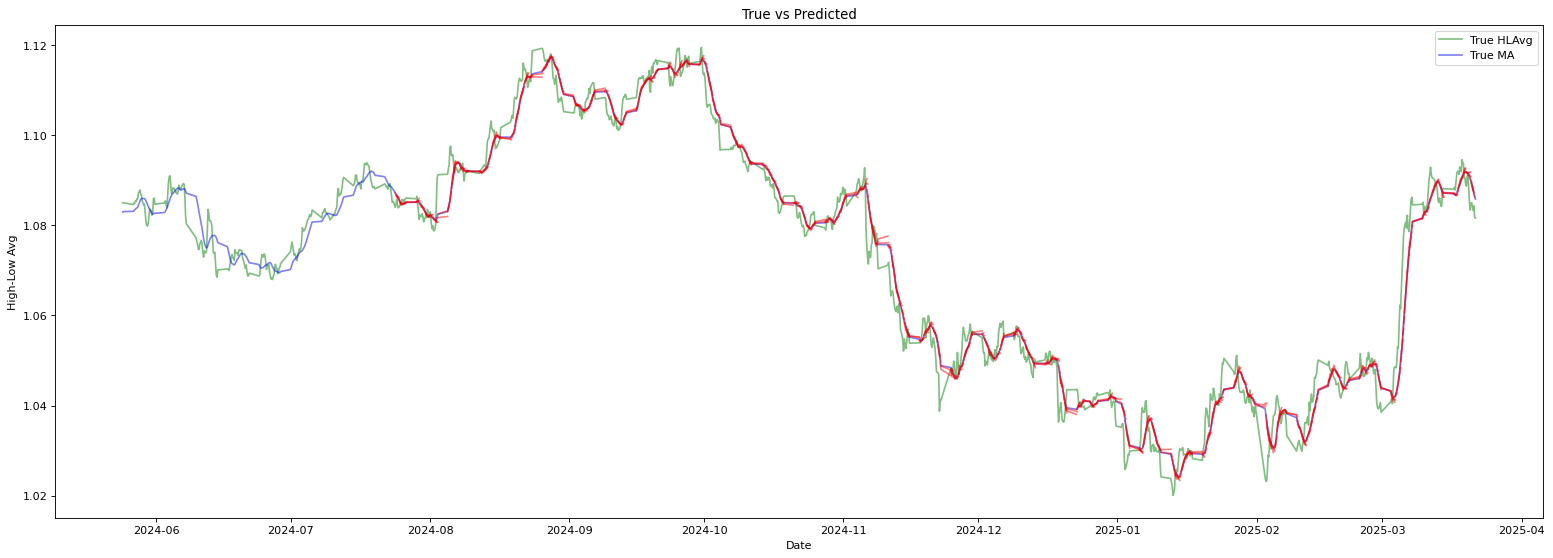

In [ ]:
plt.figure(figsize=(24, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df['HLAvg'], color = 'green', label = 'True HLAvg', alpha=0.5)
plt.plot(df['MA'], color = 'blue', label = 'True MA', alpha=0.5)
for i in range(len(predictions_for_plot)):
    plt.plot(predictions_for_plot[i], color = 'red', alpha=0.5)
plt.title('True vs Predicted')
plt.xlabel('Date')
plt.ylabel('High-Low Avg')
plt.legend()
plt.show()